In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# matplotlib Einstellungen
%config InlineBackend.figure_formats = ['svg','png']
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (7,5)
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [3]:
# initialize random number generator
rng = np.random.default_rng(seed=42)

# Aufgabe 39 Kolmogorow-Smirnow-Test 

Zu Untersuchen: Ähnlichkeit von Poisson- und Gauß-Verteilung

Nullhypothese:  
Die beiden Datensätze stammen aus der gleichen Verteilung  

Datensätze aus Poisson- und Gauß-Verteilung

Ab welchem $\lambda = \mu = \sigma^2$ können die beiden Verteilungen nicht mehr unterschieden werden? 

## a) Wie sind $\mu$ und $\sigma$ der Gauß-Verteilung zu wählen um der Poisson-Verteilung mit $\lambda$ ähnlich zu sein?  

Wähle $\mu = \sigma^2 = \lambda$

Laut Wikipedia gilt die Ähnlichkeit ab einem $\lambda \approx 30$.  
Allerdings ist die Poisson-Verteilung für diskrete Werte und die Gauß-Verteilung für kontinuierliche Werte.

## b) Kolmogorow-Smirnow-Test Implementierung

Teste ob zwei gebinnte Datensätze $X, Y$ aus der gleichen Verteilung stammen.  
Nullhypothese: Die Datensätze folgen dergleichen Verteilung

Dafür bilde die kumulierten Verteilungsfunktionen $S_X, S_Y$. (normiert auf 1)

Test Statistik: $d_\text{max} = \max_z |S_X(z) - S_Y(z)|$

Lehne den Test ab wenn $\sqrt{\frac{n_X \cdot n_Y}{n_X + n_Y}} \cdot d_\text{max} > K_\alpha$  
Wobei für große $n_X, n_Y$ gilt $K_\alpha = \sqrt{\ln(2/\alpha)/2}$

In [4]:
def kstest(X, Y, alpha):
    """
    Kolmogorov-Smirnow-Test
    Test if X and Y follow the same distribution
    X,Y are binned datasets
    requirement: same binning
    
    return False if the Test is rejected
    return True if the Test is not rejected
    """
    n_X = np.sum(X)
    n_Y = np.sum(Y)
    
    # Bilde die kummulierte Verteilungsfunktionen
    S_X = np.cumsum(X)/n_X
    S_Y = np.cumsum(Y)/n_Y
    
    # Bestimme den maximalen Abstand
    d_max = np.max(np.abs(S_X-S_Y))
    
    K_alpha = np.sqrt(np.log(2/alpha)/2)
    
    return np.sqrt(n_X*n_Y/(n_X+n_Y))*d_max <= K_alpha

## c) Prüfe Ähnlichkeit von Poisson- und Gauß-Verteilung

### Erstelle gebinnte Datensätze der Poisson- und Gauß-Verteilung

- 10000 Zufallszahlen pro Verteilung
- Gauß-Verteilte Zahlen auf ganze Zahlen runden
- 100 Bins im Intervall $[\mu - 5\sigma, \mu + 5\sigma]$

In [5]:
def drawRawData(lam, size):
    # Poissonverteilte Zahlen ziehen
    x_P = rng.poisson(lam, size)
    # Normalverteilte Zahlen ziehen
    x_G = rng.normal(lam, np.sqrt(lam), size)
    return x_P, x_G

In [6]:
def generateData(lam, size=10000, n_bins=100):
    mu = lam
    sigma = np.sqrt(lam)
    x_P, x_G = drawRawData(lam=lam, size=size)
    
    # Runde die Normalverteilten Zahlen zu ganzen Zahlen
    x_G = np.round(x_G)
    
    # Bin-Grenzen:
    bins = np.linspace(mu-5*sigma, mu+5*sigma, n_bins+1)
    
    # Gebinnte Datensätze
    x_P_binned, _ = np.histogram(x_P, bins)
    x_G_binned, _ = np.histogram(x_G, bins)
    
    return bins, x_P_binned, x_G_binned

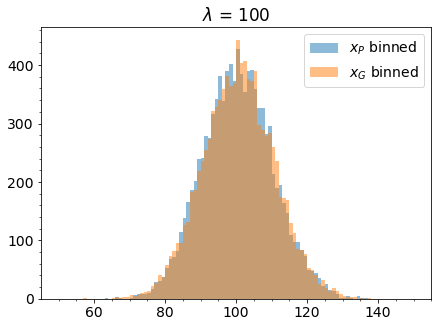

In [7]:
# Plotte ein Beispiel 
lam = 100
bins, x_P, x_G = generateData(lam=lam)

bin_widths = np.diff(bins)
bin_centers = bins[:-1] + bin_widths/2

plt.title(f'$\lambda$ = {lam}')
plt.bar(bin_centers, x_P, width=bin_widths, alpha=0.5, label='$x_P$ binned')
plt.bar(bin_centers, x_G, width=bin_widths, alpha=0.5, label='$x_G$ binned')
plt.legend()
plt.show()

### Ab welchem $\lambda$ kann die Nullhypothese bei einem $\alpha = 5\%$ nicht mehr verworfen werden?

- Führe den Kolmogorov-Test für jedes $\lambda \in [1,10000]$ durch.

In [8]:
from tqdm.auto import tqdm

In [9]:
alpha = 0.05
lams = range(1,10000)
results = np.zeros_like(lams)
for i,lam in enumerate(tqdm(lams)):
    bins, x_P, x_G = generateData(lam)
    results[i] = kstest(x_P, x_G, alpha)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [10]:
results

array([0, 0, 0, ..., 1, 1, 1])

Erklärung der Plots weiter unten:   
Die Frage ist, ab wann der Test nur noch True zurückgibt.  
Dafür ist im Plot aufgetragen wie viele Tests bis zu $\lambda$ abgelehnt wurden.  
Da im Optimalfall ab einem bestimmten $\lambda_0$ keine Tests mehr abgelehnt werden sollten,  
sollte der Plot ab $\lambda_0$ konstant bleiben, bzw. eine Steigung von nahezu 0 haben.

In [11]:
cumulated_rejections = np.cumsum(results == 0)

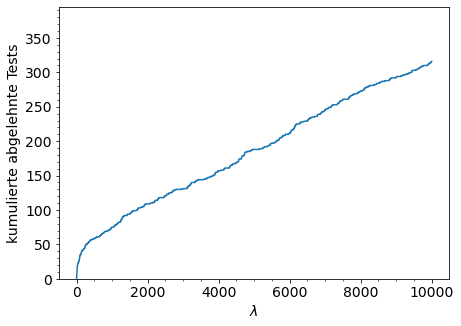

In [12]:
# Ergebnisse im Plot darstellen
plt.plot(cumulated_rejections)
plt.ylim(0, 1.25*cumulated_rejections[-1])
plt.xlabel('$\lambda$')
plt.ylabel('kumulierte abgelehnte Tests')
plt.show()

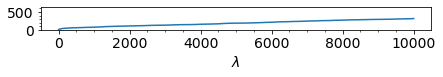

In [13]:
# Ergebnisse im Plot darstellen (aspect = equal)
plt.gca().set_aspect('equal')
plt.plot(cumulated_rejections)
plt.ylim(0, 2*cumulated_rejections[-1])
plt.xlabel('$\lambda$')
plt.show()

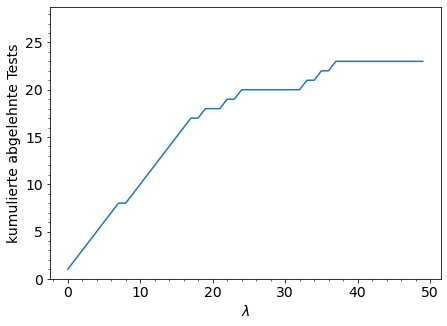

In [14]:
# Ergebnisse im Plot darstellen (nur die ersten 50 Lambda)
plt.plot(cumulated_rejections[:50])
plt.ylim(0, 1.25*cumulated_rejections[:50][-1])
plt.xlabel('$\lambda$')
plt.ylabel('kumulierte abgelehnte Tests')
plt.show()

In den Plots sieht man, dass auch bei $\lambda \approx 10000$ noch Tests abgelehnt werden.  
Auch wenn die Steigung sehr gering ist (siehe 2ter Plot).  

Also ist entweder in unserer Analyse etwas schiefgelaufen oder es gibt keine klare Grenze  
ab der sich Poisson- und Gauß-Verteilung so sehr ähneln, dass der Test diese nicht mehr unterscheiden kann.

## d) wie c) nur mit $\alpha = 2.5\%$ und $\alpha = 0.1\%$

  0%|          | 0/9999 [00:00<?, ?it/s]

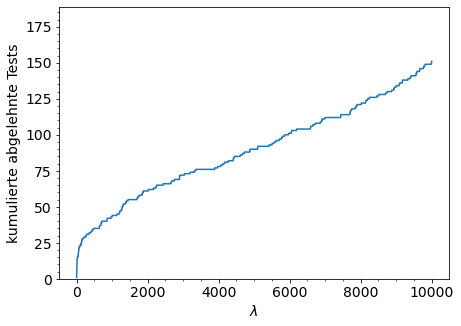

In [15]:
alpha = 0.025
lams = range(1,10000)
results = np.zeros_like(lams)
for i,lam in enumerate(tqdm(lams)):
    bins, x_P, x_G = generateData(lam)
    results[i] = kstest(x_P, x_G, alpha)
    
cumulated_rejections = np.cumsum(results == 0)

# Ergebnisse im Plot darstellen
plt.plot(cumulated_rejections)
plt.ylim(0, 1.25*cumulated_rejections[-1])
plt.xlabel('$\lambda$')
plt.ylabel('kumulierte abgelehnte Tests')
plt.show()

  0%|          | 0/9999 [00:00<?, ?it/s]

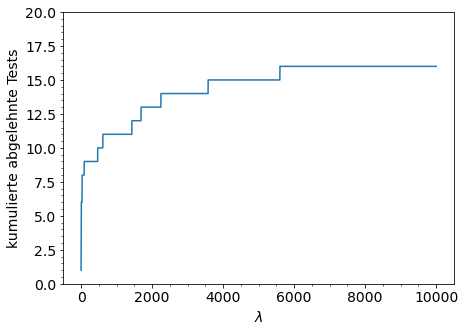

In [16]:
alpha = 0.001
lams = range(1,10000)
results = np.zeros_like(lams)
for i,lam in enumerate(tqdm(lams)):
    bins, x_P, x_G = generateData(lam)
    results[i] = kstest(x_P, x_G, alpha)
    
cumulated_rejections = np.cumsum(results == 0)

# Ergebnisse im Plot darstellen
plt.plot(cumulated_rejections)
plt.ylim(0, 1.25*cumulated_rejections[-1])
plt.xlabel('$\lambda$')
plt.ylabel('kumulierte abgelehnte Tests')
plt.show()

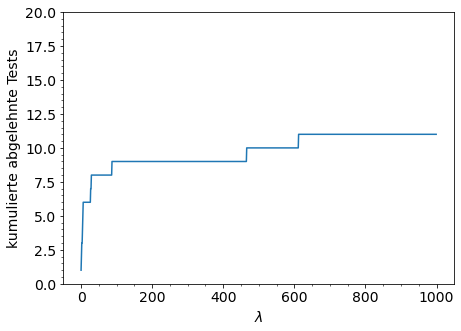

In [17]:
# Ergebnisse im Plot darstellen
plt.plot(cumulated_rejections[:1000])
plt.ylim(0, 1.25*cumulated_rejections[-1])
plt.xlabel('$\lambda$')
plt.ylabel('kumulierte abgelehnte Tests')
plt.show()

Auch hier lässt sich erkennen, dass es keine klare Grenze ergibt, wobei bei $\alpha = 0.1\%$ die Grenze $\lambda_0 \approx 150$ schon ganz gut passt.

# Aufgabe 40 Ballon-Experiment 

Die analytischen Berechnungen sind im Handschrift Teil weiter unten.

## a) Maximum Likelihood mit $\lambda_i = \lambda$

$$\hat{\lambda} = \frac{1}{N} \sum_{i=1}^N k_i$$

In [18]:
K = np.array([4135, 4202, 4203, 4218, 4227, 4231, 4310]).astype(float)
T = np.array([1, 2, 3, 4, 5, 6, 7]).astype(float)
N = len(K)

In [19]:
lam = 1/N*np.sum(K)
print(f'lambda = {lam}')

lambda = 4218.0


## b) Maximum Likelihood mit $\lambda_i = t_i \cdot \alpha + \beta$

$$F(\alpha, \beta | \vec{k}, \vec{t}) = -\ln (L(\alpha, \beta | \vec{k}))$$
$$F(\alpha, \beta | \vec{k}, \vec{t}) = - \sum_{i=1}^N k_i \ln(t_i \alpha + \beta) - \ln(k_i!) - (t_i \alpha + \beta)$$

Minimiere F numerisch.

In [20]:
def F(x):
    a = x[0]
    b = x[1]
    summands = [k_i*np.log(t_i*a+b) - (t_i*a + b) for t_i,k_i in zip(T,K)]
    return -np.sum(summands, axis=0) # - np.log(np.factorial(K))

In [21]:
from scipy.optimize import minimize

In [22]:
result = minimize(F, x0=[20, 4000])
a, b = result.x
print(f'alpha = {a:.2f}')
print(f'beta = {b:.2f}')

alpha = 21.34
beta = 4132.97


## c) Likelihood-Quotienten-Test mit Wilks Theorem

$$ \Gamma(\vec{k}, \vec{t}) = \frac{ \text{sup}_{\vec{\lambda_0}} (L( \vec{\lambda} | \vec{k} )) }{ \text{sup}_{\vec{\lambda_1}}(L(\vec{\lambda} | \vec{k})) }$$  
$$ D = -2 \ln(\Gamma(\vec{k}, \vec{t})) $$  
$$ D = -2 \sum_{i=1}^N k_i \ln(t_i \hat{\alpha} + \hat{\beta}) - k_i \ln(\hat{\lambda}) - (t_i \hat{\alpha} + \hat{\beta}) + \hat{\lambda} $$  
$$\text{Signifikanz } = \sqrt{|D|} \cdot \sigma$$  

In [23]:
def D(K,T,a,b,lam):
    summands = K*np.log(T*a+b) - K*np.log(lam) - (T*a+b) + lam
    return -2* np.sum(summands)

In [24]:
D_c = D(K,T,a,b,lam)
significance_c = np.sqrt(-D_c)
print(f'D_c = {D_c}')
print(f'Signifikanz = {significance_c:.4f} * sigma')

D_c = -3.1172917158455675
Signifikanz = 1.7656 * sigma


## d) Ein weiterer Messwert $(k = 4402, t = 14)$

In [25]:
K_d = np.append(K, 4402)
T_d = np.append(T, 14)

In [26]:
D_d = D(K_d,T_d,a,b,lam)
significance_d = np.sqrt(-D_d)
print(f'D_d = {D_d}')
print(f'Signifikanz = {significance_d:.4f} * sigma')

D_d = -10.82967862377518
Signifikanz = 3.2908 * sigma


Ohne dem Messwert an Tag 14 erhalten wir:  
$\alpha_c = 1.7656 \sigma$  
Mit dem Messwert an Tag 14 erhalten wir:  
$\alpha_d = 3.2908 \sigma$

Die Signifikanz aus der c) ist mit $\approx 1.8$ recht gering und die Steigung in den Messwerten könnte auch durch Zufall kommen.

Die Signifikanz aus der d) ist mit $\approx 3.3$ schon recht hoch und es ist anzunehmen, dass der Kollege Recht hatte mit der Annahme einer steigenden Zählrate.